## 1. 환경 설정  
필요 라이브러리를 임포트하고, 한글 폰트를 설정합니다.   (이거 지피티아님 내 수제 글임)   

============================================================

df_final : 병원1에서 병원 별로 데이터 있음
df_result,gdf_merged : 병원1에서 생활권 별로 데이터 있음


df_detail : 병원2에서 병원 별로 데이터 있음 
gdf_map_scaled : 병원2에서 생활권 별로 데이터 있음 + 전문 병원별로 점수를 부여함


In [330]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import time
import re
import folium
import branca.colormap as cm
import geopandas as gpd
from shapely.geometry import Point


In [331]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import MinMaxScaler

In [332]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

## 2. 병원정보서비스 분석  

### 2-1. 데이터 전처리   

데이터 : csv로 변환한 엑셀파일. 데이터의 구조를 살펴보고 전처리 작업을 진행합니다.   
이 아래는 df_final 만들기 전까지 패스해도됩니다.

#### 2-1-1. 병원_최종 csv파일 만듦. (볼필요X)

In [341]:
df = pd.read_csv(r"data/병원1.csv",encoding='utf-8')

In [342]:
df.head() #데이터 구조 확인

,암호화요양기호,요양기관명,종별코드,종별코드명,시도코드,시도코드명,시군구코드,시군구코드명,읍면동,우편번호,...,치과인턴 인원수,치과레지던트 인원수,치과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,조산사 인원수,좌표(X),좌표(Y)
0,JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 성빈센트병원,1,상급종합,310000,경기,310603,수원팔달구,지동,16247,...,0,0,7,0,0,0,0,0,127.027427,37.277985
1,JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교인천성모병원,1,상급종합,220000,인천,220003,인천부평구,부평동,21431,...,0,0,3,0,0,0,0,0,126.724899,37.484831
2,JDQ4MTYyMiM1MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...,강릉아산병원,1,상급종합,320000,강원,320100,강릉시,사천면,25440,...,0,0,2,0,0,0,0,0,128.857841,37.818433
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,강북삼성병원,1,상급종합,110000,서울,110016,종로구,평동,3181,...,0,0,4,0,0,0,0,0,126.967750,37.568408
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,건국대학교병원,1,상급종합,110000,서울,110023,광진구,화양동,5030,...,0,0,2,0,0,0,0,0,127.071828,37.540376


In [343]:
df.info

<bound method DataFrame.info of                                                  암호화요양기호          요양기관명  종별코드  \
0      JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...  가톨릭대학교 성빈센트병원     1   
1      JDQ4MTYyMiM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...   가톨릭대학교인천성모병원     1   
2      JDQ4MTYyMiM1MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...         강릉아산병원     1   
3      JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...         강북삼성병원     1   
4      JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...        건국대학교병원     1   
...                                                  ...            ...   ...   
78477  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkMzgxNzAyIzUxIyQxIy...      힘찬세상경희한의원    93   
78478  JDQ4MTAxMiM1MSMkMSMkMCMkMTMkNDgxOTYxIzIxIyQxIy...          힘찬한의원    93   
78479  JDQ4MTYyMiM2MSMkMSMkMiMkMTMkNDgxOTYxIzExIyQxIy...          힘찬한의원    93   
78480  JDQ4MTYyMiM4MSMkMSMkNCMkMTMkNDgxMzUxIzMxIyQxIy...          힘찬한의원    93   
78481  JDU4MTI3MSM1MSMkMSMkMCMkMTMkNDgxOTYxIzMxIyQxIy...          힘찬한의원    93

In [344]:
df.isnull().sum() #x,y 좌표가 좀 비어있음.

암호화요양기호           0
요양기관명             0
종별코드              0
종별코드명             0
시도코드              0
시도코드명             0
시군구코드             0
시군구코드명            0
읍면동             520
우편번호              0
주소                0
전화번호            484
병원홈페이지        70134
개설일자              0
총의사수              0
의과일반의 인원수         0
의과인턴 인원수          0
의과레지던트 인원수        0
의과전문의 인원수         0
치과일반의 인원수         0
치과인턴 인원수          0
치과레지던트 인원수        0
치과전문의 인원수         0
한방일반의 인원수         0
한방인턴 인원수          0
한방레지던트 인원수        0
한방전문의 인원수         0
조산사 인원수           0
좌표(X)          1488
좌표(Y)          1488
dtype: int64

In [345]:
df.columns # 컬럼 확인, 불필요한 컬럼 삭제

Index(['암호화요양기호', '요양기관명', '종별코드', '종별코드명', '시도코드', '시도코드명', '시군구코드', '시군구코드명',
       '읍면동', '우편번호', '주소', '전화번호', '병원홈페이지', '개설일자', '총의사수', '의과일반의 인원수',
       '의과인턴 인원수', '의과레지던트 인원수', '의과전문의 인원수', '치과일반의 인원수', '치과인턴 인원수',
       '치과레지던트 인원수', '치과전문의 인원수', '한방일반의 인원수', '한방인턴 인원수', '한방레지던트 인원수',
       '한방전문의 인원수', '조산사 인원수', '좌표(X)', '좌표(Y)'],
      dtype='object')

In [346]:
df2 = df.drop(columns=['암호화요양기호','전화번호','병원홈페이지','종별코드','시도코드','시군구코드','개설일자','치과일반의 인원수','치과인턴 인원수','치과레지던트 인원수','치과전문의 인원수','조산사 인원수'])

In [347]:
df2.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,0,0,0,0,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,0,0,0,0,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,0,0,0,0,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,0,0,0,0,127.071828,37.540376


In [348]:
def get_coords_vworld(address, vworld_api_key):
    url = "https://api.vworld.kr/req/address"
    params = {
        "service": "address",
        "request": "getcoord",
        "version": "2.0",
        "crs": "EPSG:4326",
        "address": address,
        "format": "json",
        "type": "ROAD",
        "key": vworld_api_key
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        result = response.json()
        try:
            x = result['response']['result']['point']['x']
            y = result['response']['result']['point']['y']
            return float(x), float(y)
        except:
            return None, None
    return None, None

def fill_missing_coords(df, api_key, delay=0.3):

    for idx, row in df.iterrows():

        full_address = row['주소']
        x, y = get_coords_vworld(full_address, api_key)
        
        if x and y:
            df.at[idx, '좌표(X)'] = x
            df.at[idx, '좌표(Y)'] = y
            print(f"✅ [{idx}] 좌표 채움: {x}, {y}")
        else:
            print(f"❌ [{idx}] 좌표 못 찾음: {full_address}")
        
        time.sleep(delay)  # 요청 간 시간 간격 (초당 3~5회 이하 추천)

    return df


In [349]:
vworld_key = "239AEE7D-C80A-374B-B39F-A2E7A556C870"

In [350]:
df_null = df[df['좌표(X)'].isna()].copy()
df_null.info

<bound method DataFrame.info of                                                  암호화요양기호                요양기관명  \
222    JDQ4MTYyMiM4MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...  의료법인 문병욱의료재단 진주고려병원   
404    JDQ4MTYyMiM3MSMkMSMkMCMkOTkkMzgxMzUxIzMxIyQxIy...                 가람병원   
595    JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...           다산청아람어린이병원   
612    JDQ4MTYyMiM4MSMkMSMkMCMkOTkkMzgxOTYxIzExIyQxIy...         대구제이케이(JK)병원   
901    JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...             샘물호스피스병원   
...                                                  ...                  ...   
78192  JDQ4MTg4MSM1MSMkMSMkOCMkMTMkMzgxNzAyIzExIyQxIy...                화리한의원   
78231  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQyIy...               화이팅한의원   
78379  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQxIy...                효인한의원   
78467  JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzUxIyQxIy...              희희호호한의원   
78476  JDQ4MTYyMiM2MSMkMSMkMiMkMTMkNDgxOTYxIzIxIyQxIy...                힘센한의원

In [351]:
df_null = fill_missing_coords(df_null, vworld_key)

✅ [222] 좌표 채움: 128.092053692, 35.178482488
✅ [404] 좌표 채움: 126.883887496, 35.174034924
✅ [595] 좌표 채움: 127.156119831, 37.625798083
✅ [612] 좌표 채움: 128.615415833, 35.854110789
✅ [901] 좌표 채움: 127.414015909, 37.138674936
✅ [942] 좌표 채움: 127.380595362, 36.345422888
✅ [1000] 좌표 채움: 129.00966708, 35.105729691
✅ [1070] 좌표 채움: 126.939098959, 37.396562315
✅ [1143] 좌표 채움: 127.047835781, 37.726541226
✅ [1163] 좌표 채움: 127.391645894, 36.340067254
✅ [1181] 좌표 채움: 126.883656962, 35.159146273
✅ [1198] 좌표 채움: 127.148454021, 37.271932782
✅ [1215] 좌표 채움: 128.617453052, 35.895286229
✅ [1324] 좌표 채움: 127.57549641, 36.777508741
✅ [1456] 좌표 채움: 127.334397066, 36.301991661
✅ [1548] 좌표 채움: 127.916787671, 35.687347682
✅ [1612] 좌표 채움: 127.495070498, 36.670963472
✅ [1614] 좌표 채움: 127.485884174, 36.636901209
✅ [1722] 좌표 채움: 129.014516634, 35.327214591
✅ [1745] 좌표 채움: 128.651910114, 35.855445545
✅ [1757] 좌표 채움: 127.238330961, 37.650088031
✅ [2288] 좌표 채움: 128.624890285, 35.843136114
✅ [2318] 좌표 채움: 126.809032346, 37.368925

In [352]:
df_without_missing = df2[~df2.index.isin(df_null.index)]
df_final = pd.concat([df_without_missing, df_null], ignore_index=True)
df_final = df_final.sort_index()

In [353]:
df_final.drop(columns=['암호화요양기호','전화번호','병원홈페이지','종별코드','시도코드','시군구코드','개설일자','치과일반의 인원수','치과인턴 인원수','치과레지던트 인원수','치과전문의 인원수','조산사 인원수'],inplace=True) # 불필요한 컬럼 삭제 

In [364]:
df_final.isnull().sum() # 좌표가 다 채워졌는지 확인

암호화요양기호           0
요양기관명             0
종별코드              0
종별코드명             0
시도코드              0
시도코드명             0
시군구코드             0
시군구코드명            0
읍면동             520
우편번호              0
주소                0
전화번호            484
병원홈페이지        70134
개설일자              0
총의사수              0
의과일반의 인원수         0
의과인턴 인원수          0
의과레지던트 인원수        0
의과전문의 인원수         0
치과일반의 인원수         0
치과인턴 인원수          0
치과레지던트 인원수        0
치과전문의 인원수         0
한방일반의 인원수         0
한방인턴 인원수          0
한방레지던트 인원수        0
한방전문의 인원수         0
조산사 인원수           0
좌표(X)          1488
좌표(Y)          1488
dtype: int64

In [365]:
none = df_final[df_final['좌표(X)'].isna() & df_final['좌표(Y)'].isna()] # 좌표가 비어있는 데이터 확인
none

,암호화요양기호,요양기관명,종별코드,종별코드명,시도코드,시도코드명,시군구코드,시군구코드명,읍면동,우편번호,...,치과인턴 인원수,치과레지던트 인원수,치과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,조산사 인원수,좌표(X),좌표(Y)
222,JDQ4MTYyMiM4MSMkMSMkNCMkODkkMzgxMzUxIzExIyQxIy...,의료법인 문병욱의료재단 진주고려병원,11,종합병원,380000,경남,380500,진주시,칠암동,52726,...,0,0,0,0,0,0,0,0,NaN,NaN
404,JDQ4MTYyMiM3MSMkMSMkMCMkOTkkMzgxMzUxIzMxIyQxIy...,가람병원,21,병원,240000,광주,240002,광주북구,운암동,61117,...,0,0,0,0,0,0,0,0,NaN,NaN
595,JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...,다산청아람어린이병원,21,병원,310000,경기,311500,남양주시,다산동,12285,...,0,0,0,0,0,0,0,0,NaN,NaN
612,JDQ4MTYyMiM4MSMkMSMkMCMkOTkkMzgxOTYxIzExIyQxIy...,대구제이케이(JK)병원,21,병원,230000,대구,230005,대구수성구,수성동2가,42132,...,0,0,0,0,0,0,0,0,NaN,NaN
901,JDQ4MTYyMiM1MSMkMSMkMCMkOTkkMzgxOTYxIzIxIyQxIy...,샘물호스피스병원,21,병원,310000,경기,312003,용인처인구,백암면,17180,...,0,0,0,0,0,0,0,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78192,JDQ4MTg4MSM1MSMkMSMkOCMkMTMkMzgxNzAyIzExIyQxIy...,화리한의원,93,한의원,110000,서울,110021,서초구,방배동,6568,...,0,0,0,1,0,0,0,0,NaN,NaN
78231,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQyIy...,화이팅한의원,93,한의원,110000,서울,110020,양천구,신정동,8093,...,0,0,0,2,0,0,0,0,NaN,NaN
78379,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzQxIyQxIy...,효인한의원,93,한의원,110000,서울,110015,은평구,불광동,3349,...,0,0,0,0,0,0,1,0,NaN,NaN
78467,JDQ4MTg4MSM1MSMkMSMkNCMkMTMkNDgxMTkxIzUxIyQxIy...,희희호호한의원,93,한의원,110000,서울,110001,강남구,대치동,6198,...,0,0,0,2,0,0,0,0,NaN,NaN


In [366]:
df_final = df_final[df_final['주소']!="전라남도 나주시 월정1길 41-201, (빛가람동)"]

In [357]:
none[none['주소']== "강원특별자치도 양구군 방산면 성곡로 1788-24503, (금악보건소)"]

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
78261,금악리보건진료,보건진료소,강원,양구군,방산면,24503,"강원특별자치도 양구군 방산면 성곡로 1788-24503, (금악보건소)",0,0,0,0,0,0,0,0,0,NaN,NaN


In [358]:
manual_coords = {
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 2층 207~208호 (반포동)' : (126.9995048,37.5049309),
    '서울특별시 용산구 새창로 217, 용산토투밸리 15층 1501호 (한강로2가)': (126.9677944,37.5302252),
    '경기도 성남시 분당구 서현로 192, 야베스밸리 303호 (서현동)': (127.1244293,37.3877936),
    '서울특별시 서초구 서초대로77길 55, 에이프로 스퀘어 10층 (서초동)': (127.0244659,37.5021008),
    '서울특별시 금천구 가산디지털1로 168, 우림라이온스밸리 C동 1층 101호 (가산동)': (126.8826362,37.4799665),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 4층 430~433호 (반포동)': (126.9995048,37.5049309),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 5층 542~545호 (반포동)': (126.9995048,37.5049309),
    '서울특별시 용산구 새창로 217, 용산토투밸리 7층 705호 (한강로2가)': (126.9677944,37.5302252),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 2층 202~204호 (반포동)': (126.9995048,37.5049309),
    '서울특별시 동대문구 왕산로32길 7, BYC 청량리 오피스텔 6층 (용두동)': (127.0418316,37.5787365),
    '인천광역시 부평구 경원대로 1404, 그랑프리 빌딩 301, 311호 (부평동)': (126.7250512,37.4909488),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 3층 346~348호 (반포동)': (126.9995048,37.5049309),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 2층 213~214호 (반포동)': (126.9995048,37.5049309),
    '경기도 성남시 분당구 성남대로 926, 분당메트로 7층 703호 (야탑동)': (127.1292920,37.4125779),
    '경기도 이천시 장호원읍 경충대로597번길 57-82, (장호원읍)': (127.5735298,37.1559879),
    '충청남도 아산시 탕정면 매곡중앙로 70, B동 2층 213~214호 (한들물빛도시지웰시티센트럴푸르지오2단지)': (127.5735298,37.1559879),
    '강원특별자치도 양구군 방산면 성곡로 1788-24503, (금악보건소)': (127.930195771871,38.1939147346811),
    '서울특별시 서초구 반포대로 291, 원베일리 스퀘어 4층 409~410호 (반포동)': (126.9995048,37.5049309),
    '경상북도 예천군 호명면 새움3로 26, 에비뉴타워 301동': (128.4896523,36.5764346),
    '대구광역시 달성군 유가읍 테크노공원로 73, 테크노밸리 1동 301호': (128.4611235,35.6920089)
}

for addr, (x, y) in manual_coords.items():
    mask = df_final['주소'].str.strip() == addr
    df_final.loc[mask, ['좌표(X)', '좌표(Y)']] = [x, y]

In [359]:
# 병원 좌표 → Point
df_final['좌표(X)'] = df_final['좌표(X)'].astype(float)
df_final['좌표(Y)'] = df_final['좌표(Y)'].astype(float)
geometry = [Point(xy) for xy in zip(df_final['좌표(X)'], df_final['좌표(Y)'])]
gdf_hosp = gpd.GeoDataFrame(df_final, geometry=geometry, crs="EPSG:4326")

# GeoJSON 불러오기 및 좌표계 통일
gdf_adm = gpd.read_file("data/HangJeongDong_ver20250401.geojson")
gdf_adm = gdf_adm.to_crs(epsg=4326)

# 공간 조인 (intersects로 변경)
gdf_joined = gpd.sjoin(gdf_hosp, gdf_adm[['adm_nm', 'geometry']], how='left', predicate='intersects')

# 읍면동 채우기
gdf_joined['읍면동'] = gdf_joined['읍면동'].fillna(gdf_joined['adm_nm'])

# 정리
df_final_updated = gdf_joined.drop(columns=['geometry', 'index_right', 'adm_nm'])

In [360]:
df_final_updated.isna().sum() # 좌표가 다 채워졌는지 확인

요양기관명         0
종별코드명         0
시도코드명         0
시군구코드명        0
읍면동           0
우편번호          0
주소            0
총의사수          0
의과일반의 인원수     0
의과인턴 인원수      0
의과레지던트 인원수    0
의과전문의 인원수     0
한방일반의 인원수     0
한방인턴 인원수      0
한방레지던트 인원수    0
한방전문의 인원수     0
좌표(X)         2
좌표(Y)         2
dtype: int64

In [361]:
df_final_updated.to_csv("병원1.csv", index=False)

#### 2-1-2. 의과&한방 분리 코드 (폐기)

In [ ]:
#df_final 만든 버전
df_final = pd.read_csv("data/병원_최종.csv",encoding='utf-8')
df_final['시도코드명'] = df_final['시도코드명'].replace('세종시', '세종')

In [ ]:
general_hospitals = []
oriental_hospitals = []

for index, row in df_final.iterrows(): #행반복복
    if row['의과일반의 인원수'] > 0 or row['의과인턴 인원수'] > 0 or row['의과레지던트 인원수'] > 0 or row['의과전문의 인원수'] > 0:
        general_hospitals.append(row)
    elif row['한방일반의 인원수'] > 0 or row['한방인턴 인원수'] > 0 or row['한방레지던트 인원수'] > 0 or row['한방전문의 인원수'] > 0:
        oriental_hospitals.append(row)

df_general = pd.DataFrame(general_hospitals)
df_oriental = pd.DataFrame(oriental_hospitals)

In [ ]:
df_final.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,0,0,0,0,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,0,0,0,0,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,0,0,0,0,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,0,0,0,0,127.071828,37.540376


In [ ]:
df_general.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,0,0,0,0,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,0,0,0,0,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,0,0,0,0,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,0,0,0,0,127.071828,37.540376


In [ ]:
df_oriental.tail()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
78477,화리한의원,한의원,서울,서초구,방배동,6568,"서울특별시 서초구 서초대로 3-4, 105호 (방배동, 디오슈페리움1차)",1,1,0,0,0,126.983124,37.486042
78478,화이팅한의원,한의원,서울,양천구,신정동,8093,"서울특별시 양천구 목동동로 67, 2층 (신정동)",2,2,0,0,0,126.862500,37.515710
78479,효인한의원,한의원,서울,은평구,불광동,3349,"서울특별시 은평구 연서로 274, 2층 (불광동)",1,0,0,0,1,126.925097,37.620572
78480,희희호호한의원,한의원,서울,강남구,대치동,6198,"서울특별시 강남구 선릉로 408, 3층 (대치동)",2,2,0,0,0,127.050740,37.501412
78481,힘센한의원,한의원,충남,논산시,화지동,32950,"충청남도 논산시 중앙로491번길 12, (화지동)",1,1,0,0,0,127.081874,36.206160


Text(0.5, 1.0, '의과 병원 분포')

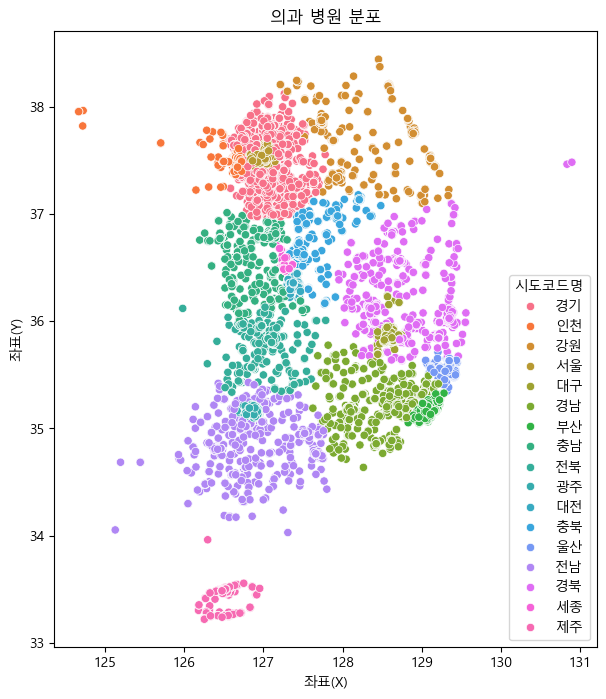

In [ ]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_general, x='좌표(X)', y='좌표(Y)', hue='시도코드명')
plt.title('의과 병원 분포')

Text(0.5, 1.0, '한방 병원 분포')

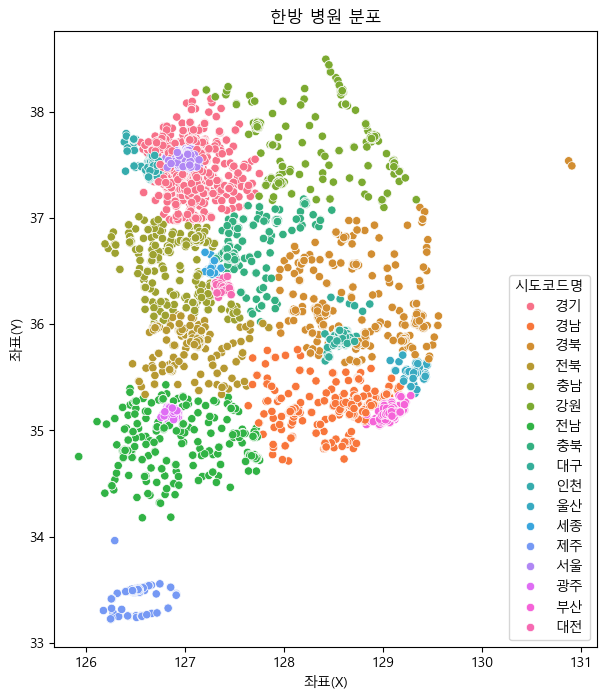

In [ ]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_oriental, x='좌표(X)', y='좌표(Y)', hue='시도코드명')
plt.title('한방 병원 분포')

#### 2-1-3. 데이터 확인 

In [372]:
#df_final 만든 버전
df_final = pd.read_csv("data/병원1_보완.csv",encoding='utf-8')
df_final.head()

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985
1,가톨릭대학교인천성모병원,상급종합,인천,인천부평구,부평동,21431,"인천광역시 부평구 동수로 56, (부평동)",248,3,0,3,238,0,0,0,0,126.724899,37.484831
2,강릉아산병원,상급종합,강원,강릉시,사천면,25440,"강원특별자치도 강릉시 사천면 방동길 38, (사천면)",176,8,0,12,154,0,0,0,0,128.857841,37.818433
3,강북삼성병원,상급종합,서울,종로구,평동,3181,"서울특별시 종로구 새문안로 29, (평동)",278,0,1,11,258,0,0,0,0,126.967750,37.568408
4,건국대학교병원,상급종합,서울,광진구,화양동,5030,"서울특별시 광진구 능동로 120-1, (화양동)",251,1,0,15,233,0,0,0,0,127.071828,37.540376


Text(0.5, 1.0, '전체 병원 분포')

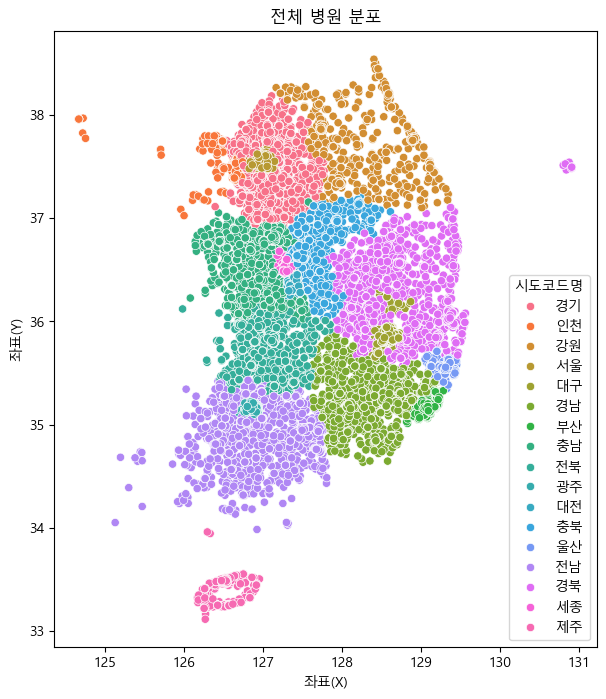

In [371]:
plt.figure(figsize=(7,8))
sns.scatterplot(data=df_final, x='좌표(X)', y='좌표(Y)', hue='시도코드명')
plt.title('전체 병원 분포')

### 2-2. 생활권역별 병원 분석   

생활권 데이터를 불러와 생활권에서 병원이 어떻게 분포하는지 확인합니다.   
어떤 생활권에 병원이 부족한지 절대적인 기준치인 생활권 단위로 확인합니다.

In [373]:
df_living = pd.read_csv("data/최종생활권.csv",encoding='utf-8')

In [374]:
df_living.head(1) #생활권이 총 2127개

,ID,시도,시군구,읍면동,행정기관코드,총인구수,어린이,노인
0,1,서울특별시;서울특별시;서울특별시,종로구;종로구;종로구,청운효자동;사직동;삼청동,1111051500;1111053000;1111054000,22112,2808,4824


In [375]:
df_final.head(1)

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,의과레지던트 인원수,의과전문의 인원수,한방일반의 인원수,한방인턴 인원수,한방레지던트 인원수,한방전문의 인원수,좌표(X),좌표(Y)
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,6,238,0,0,0,0,127.027427,37.277985


#### 2-3-1. 병원 밀도 분석 (폐기)
시도별로 병원 밀도 분석 코드

In [376]:
df_general['시도코드명'].unique()

array(['경기', '인천', '강원', '서울', '대구', '경남', '부산', '충남', '전북', '광주', '대전',
       '충북', '울산', '전남', '경북', '세종', '제주'], dtype=object)

In [ ]:
data_human = {
    '시도명': ['서울', '부산', '대구', '인천', '광주', '대전', '울산', '세종', '경기',
             '강원', '충북', '충남', '전북', '전남', '경북', '경남', '제주'],
    '인구(천명)': [15567, 4282, 2679, 2788, 2933, 2728, 1048, 818, 1342,
             91, 219, 265, 220, 144, 138, 312, 365],
    '인구밀도': [9400, 3284, 2360, 3009, 1463, 1474, 1106, 387, 13781,
                1525, 1627, 2204, 1768, 1768, 2611, 3267, 677]
} # 시도별 인구수 및 인구밀도 데이터. 2023년 확정인구 기준. 
df_human = pd.DataFrame(data_human).set_index('시도명')

In [ ]:
hospital_counts = df_final['시도코드명'].value_counts()
df_human['병원수'] = hospital_counts # 시도별 병원 수 데이터 추가
df_human['병원수'] = df_human['병원수'].fillna(0) # 병원 수가 없는 시도는 0으로 채움

In [ ]:
df_human['병원밀도(개/1만명)'] = (df_human['병원수'] / (df_human['인구(천명)'] * 1000)) * 10000
df_human = df_human.sort_values('병원밀도(개/1만명)')

In [ ]:
df_human

,인구(천명),인구밀도,병원수,병원밀도(개/1만명)
시도명,,,,
세종,818,387,464,5.672372
광주,2933,1463,2326,7.930447
대전,2728,1474,2355,8.632698
서울,15567,9400,19277,12.383247
부산,4282,3284,5585,13.042971
울산,1048,1106,1429,13.635496
인천,2788,3009,3818,13.694405
대구,2679,2360,4171,15.569242
제주,365,677,1043,28.575342


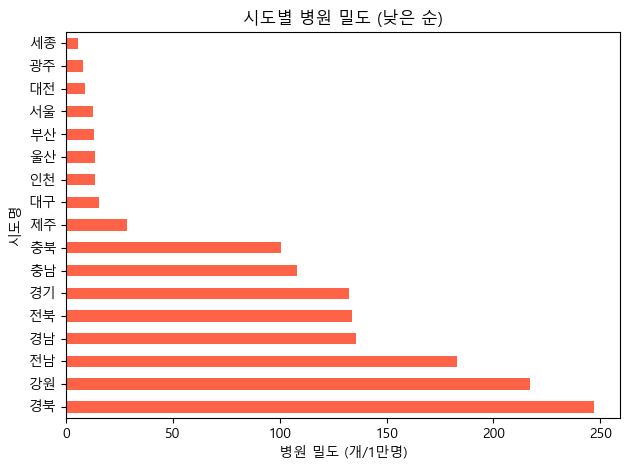

In [ ]:
df_human['병원밀도(개/1만명)'].plot(kind='barh', color='tomato') #토마토
plt.xlabel('병원 밀도 (개/1만명)')
plt.title('시도별 병원 밀도 (낮은 순)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
df_human2 = pd.DataFrame(data_human).set_index('시도명')

general_counts = df_general['시도코드명'].value_counts()
oriental_counts = df_oriental['시도코드명'].value_counts()

df_human2['일반병원수'] = general_counts
df_human2['한방병원수'] = oriental_counts
df_human2 = df_human2.fillna(0)


df_human2['일반병원 밀도'] = (df_human2['일반병원수'] / (df_human2['인구(천명)'] * 1000)) * 10000
df_human2['한방병원 밀도'] = (df_human2['한방병원수'] / (df_human2['인구(천명)'] * 1000)) * 10000

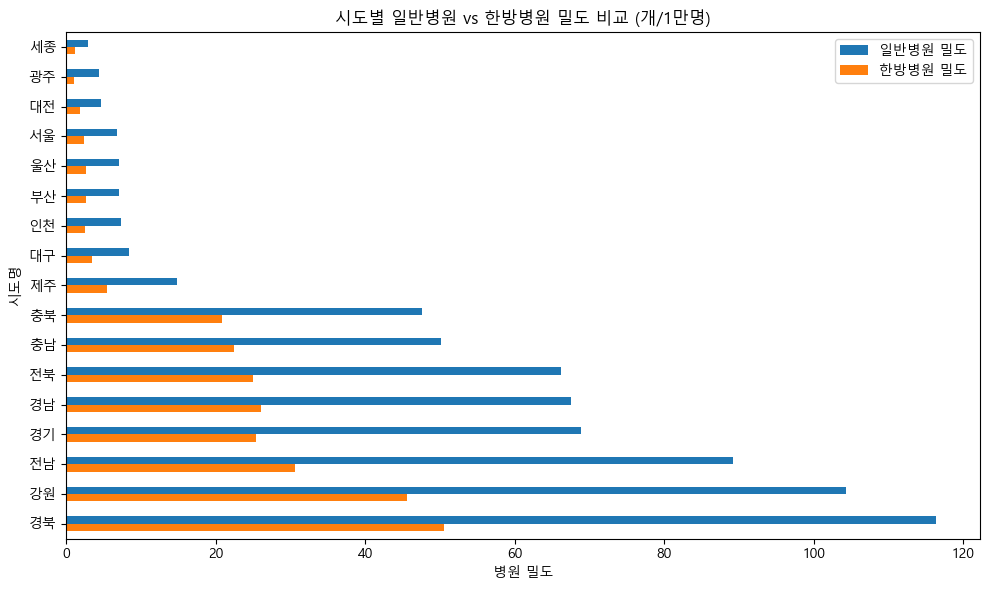

In [ ]:
df_human2[['일반병원 밀도', '한방병원 밀도']].sort_values('일반병원 밀도').plot(kind='barh', figsize=(10,6))
plt.title('시도별 일반병원 vs 한방병원 밀도 비교 (개/1만명)')
plt.xlabel('병원 밀도')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

#### 2-3-2. 생활권 별 병원 밀도   
df_final : 요양기관명, 위치(읍면동,우편번호,주소,좌표), 총의사수, 외과&한방 의사수   
df_living : ID, 위치(시도,시군구,읍면동),행정코드, 총인구수, 아동&노인 인구수

In [377]:
# 1. 고유한 읍면동 이름 추출
final_eupmyeondong_set = set(df_final['읍면동'].unique())

# 2. 생활권 데이터의 읍면동을 분리 및 정제
living_eupmyeondong_series = df_living['읍면동'].str.split(';').explode().str.strip()
living_eupmyeondong_set = set(living_eupmyeondong_series.unique())

# 3. 이름 불일치 확인
only_in_final = final_eupmyeondong_set - living_eupmyeondong_set
only_in_living = living_eupmyeondong_set - final_eupmyeondong_set

# 4. 일부 결과와 총 개수 확인
print("병원에는 있지만 생활권에는 없는 읍면동:", sorted(list(only_in_final)))
print("생활권에는 있지만 병원에는 없는 읍면동:", sorted(list(only_in_living)))
print("병원만 있는 읍면동 수:", len(only_in_final))
print("생활권만 있는 읍면동 수:", len(only_in_living))


병원에는 있지만 생활권에는 없는 읍면동: ['가람동', '가수동', '가야동', '가양동', '가오동', '가음동', '가정동', '가현동', '가흥동', '각산동', '각화동', '간석동', '갈곶동', '갈마동', '갈월동', '감만동', '감이동', '감정동', '감천동', '갑제동', '강동', '강문동', '강산동', '강정동', '강제동', '강흥동', '개금동', '개봉동', '개신동', '개포동', '거모동', '거여동', '거제동', '건건동', '걸포동', '검사동', '검암동', '견지동', '경기도 고양시덕양구 화전동', '경기도 고양시덕양구 효자동', '경기도 고양시일산동구 마두1동', '경기도 고양시일산동구 마두2동', '경기도 고양시일산동구 백석1동', '경기도 고양시일산동구 백석2동', '경기도 고양시일산동구 장항2동', '경기도 고양시일산동구 정발산동', '경기도 고양시일산동구 중산1동', '경기도 고양시일산서구 대화동', '경기도 고양시일산서구 일산3동', '경기도 고양시일산서구 주엽1동', '경기도 고양시일산서구 주엽2동', '경기도 과천시 원문동', '경기도 과천시 중앙동', '경기도 광주시 남한산성면', '경기도 광주시 능평동', '경기도 광주시 오포1동', '경기도 광주시 오포2동', '경기도 김포시 구래동', '경기도 부천시소사구 송내1동', '경기도 부천시소사구 송내2동', '경기도 성남시수정구 신흥3동', '경기도 성남시수정구 위례동', '경기도 성남시중원구 성남동', '경기도 수원시영통구 광교1동', '경기도 수원시팔달구 매산동', '경기도 용인시기흥구 구갈동', '경기도 용인시수지구 상현3동', '경기도 의정부시 고산동', '경기도 평택시 동삭동', '경기도 평택시 비전2동', '경기도 평택시 세교동', '경기도 하남시 미사1동', '경기도 화성시 남양읍', '경기도 화성시 동탄4동', '경기도 화성시 동탄7동', '경동', '경상남도 김해시 주촌면', '경상남도 창원시마산합포구 교방동', '경상남도 창원시성산구

**지금 df_final에 ID를 부여함. 좌표를 이용해서 어떤 생활권에 포함되는지 판단 후, ID를 부여함. 이후 df_living과 병합할 때 ID기준준 **

In [386]:
if 'ID' in df_final.columns:
    df_final = df_final.drop(columns='ID')

# 1. 병원 df를 GeoDataFrame으로 변환
df_final['geometry'] = df_final.apply(lambda row: Point(row['좌표(X)'], row['좌표(Y)']), axis=1)
df_final = gpd.GeoDataFrame(df_final, geometry='geometry', crs="EPSG:4326")

# 2. 생활권 GeoJSON 불러오기
gdf_living = gpd.read_file("data/only생활권.geojson")
gdf_living['ID'] = gdf_living['ID'].astype(int)

# 3. 공간 조인 (병원이 포함된 생활권 ID를 매핑)
df_final = gpd.sjoin(df_final, gdf_living[['ID', 'geometry']], how='left', predicate='within')

# 5. 필요시 저장
# df_final.to_file("병원_생활권_매핑결과.geojson", driver="GeoJSON")

In [387]:
# 4. 결과 확인
df_final.head(1)

,요양기관명,종별코드명,시도코드명,시군구코드명,읍면동,우편번호,주소,총의사수,의과일반의 인원수,의과인턴 인원수,...,한방전문의 인원수,좌표(X),좌표(Y),geometry,ID_left,ID_right,의과+한방,병원_수,index_right,ID
0,가톨릭대학교 성빈센트병원,상급종합,경기,수원팔달구,지동,16247,"경기도 수원시 팔달구 중부대로 93, (지동)",251,0,0,...,0,127.027427,37.277985,POINT (127.02743 37.27799),958.0,958.0,244,1,954.0,958.0


In [388]:
# 1. 의과+한방 의사 수 합계 컬럼 생성
df_final['의과+한방'] = (
    df_final[['의과일반의 인원수', '의과전문의 인원수', '의과레지던트 인원수', '의과인턴 인원수']].sum(axis=1) +
    df_final[['한방일반의 인원수', '한방전문의 인원수', '한방레지던트 인원수', '한방인턴 인원수']].sum(axis=1)
)

# 2. 병원 수 추가
df_final['병원_수'] = 1

# 3. ID가 있는 병원만 필터링
df_valid = df_final.dropna(subset=['ID']).copy()
df_valid['ID'] = df_valid['ID'].astype(int)

# 4. ID 기준 병원 및 의사 수 집계
df_summary = df_valid.groupby('ID', as_index=False).agg({
    '병원_수': 'sum',
    '의과+한방': 'sum'
}).rename(columns={'의과+한방': '의사수', '병원_수': '병원수'})

# 5. df_living에서 인구 정보 추출
df_demo = df_living[['ID', '읍면동', '총인구수', '어린이', '노인']].copy()
df_demo['ID'] = df_demo['ID'].astype(int)

# 6. 병원+의사 수와 인구 정보 병합
df_result = df_demo.merge(df_summary, on='ID', how='left').fillna({'병원수': 0, '의사수': 0})

# 결과 확인
df_result.head()


,ID,읍면동,총인구수,어린이,노인,병원수,의사수
0,1,청운효자동;사직동;삼청동,22112,2808,4824,95.0,129.0
1,2,부암동;평창동,26249,3568,5874,18.0,19.0
2,3,무악동;교남동,17341,2810,3318,27.0,391.0
3,4,가회동;종로1.2.3.4가동;종로5.6가동;이화동,22735,1624,5234,233.0,1230.0
4,5,혜화동;창신제1동;창신제2동,27638,2394,6065,80.0,76.0


In [389]:
# 1. GeoJSON 불러오기
gdf = gpd.read_file("data/only생활권.geojson")
gdf["ID"] = gdf["ID"].astype(int)

# 🔹 3. ID 기준으로 생활권 단위로 dissolve (하나의 폴리곤으로 묶기)
gdf = gdf.dissolve(by="ID", as_index=False)

# 4. df_result에 취약계층 컬럼 추가
df_result["취약계층"] = df_result["어린이"] + df_result["노인"]
df_result["ID"] = df_result["ID"].astype(int)

# 5. 병합
gdf_merged = gdf.merge(df_result, on="ID", how="left")

# 6. _x와 _y 처리
for col in gdf_merged.columns:
    if col.endswith("_x") and col[:-2] + "_y" in gdf_merged.columns:
        base = col[:-2]
        gdf_merged[base] = gdf_merged[col].combine_first(gdf_merged[base + "_y"])
        gdf_merged = gdf_merged.drop(columns=[col, base + "_y"])

# 7. 시각화용 컬럼 계산
gdf_merged["의료자원"] = gdf_merged["병원수"] + gdf_merged["의사수"]
colormap = cm.linear.YlOrRd_09.scale(
    gdf_merged["의료자원"].min(),
    gdf_merged["의료자원"].max()
)
colormap.caption = "생활권별 의료자원 (병원 수 + 의사 수)"

# 8. 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7)

# 9. GeoJson 시각화
folium.GeoJson(
    gdf_merged,
    name="생활권 의료자원",
    tooltip=folium.GeoJsonTooltip(
        fields=["ID", "읍면동","총인구수", "취약계층", "병원수", "의사수", "의료자원"],
        aliases=["ID", "읍면동", "총인구수", "취약계층", "병원수", "의사수", "의료자원"],
        localize=True
    ),
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["의료자원"]) if feature["properties"]["의료자원"] else "lightgray",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.7,
    },
).add_to(m)

colormap.add_to(m)

# 10. 저장
m.save("생활권_의료자원.html")
gdf_merged.to_file("생활권_의료자원.geojson", driver="GeoJSON")

C:\Users\zappe\AppData\Local\Temp\ipykernel_53760\900061308.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gdf_merged[base] = gdf_merged[col].combine_first(gdf_merged[base + "_y"])
C:\Users\zappe\AppData\Local\Temp\ipykernel_53760\900061308.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no longer exclude empty items when determining the result dtype. To retain the old behavior, exclude the empty entries before the concat operation.
  gdf_merged[base] = gdf_merged[col].combine_first(gdf_merged[base + "_y"])
C:\Users\zappe\AppData\Local\Temp\ipykernel_53760\900061308.py:19: FutureWarning: The behavior of array concatenation with empty entries is deprecated. In a future version, this will no 

##### 분석 목표   
상대적으로 의료서비스 접근성이 낮은 지역을 생활권 단위로 도출한다. 의료자원 대비 수요가 높은 지역 = 공급 부족 지역으로 판단.   
인구 1000명 당 병원 수를 계산하여 의료자원 밀도를 평가한 후, 취약계층 비율을 고려한다. 의료자원 지수도 단순 병원수+의사수가 아닌 정규화 후 평균을 낼 예정이다.

In [390]:
gdf_merged['인구1천명당_병원수'] = gdf_merged['병원수'] / (gdf_merged['총인구수'] / 1000)
gdf_merged['인구1천명당_의사수'] = gdf_merged['의사수'] / (gdf_merged['총인구수'] / 1000)

gdf_merged['취약계층비율'] = (gdf_merged['어린이'] + gdf_merged['노인']) / gdf_merged['총인구수']

In [391]:
scaler = MinMaxScaler()
gdf_merged[['병원수_norm', '의사수_norm']] = scaler.fit_transform(gdf_merged[['병원수', '의사수']])
gdf_merged['의료자원지수'] = (gdf_merged['병원수_norm'] + gdf_merged['의사수_norm']) / 2


In [392]:
threshold_medical = gdf_merged['의료자원지수'].quantile(0.2)
threshold_vulnerable = gdf_merged['취약계층비율'].quantile(0.8)
threshold_doctor_density = gdf_merged['인구1천명당_의사수'].quantile(0.2)

gdf_merged['취약생활권'] = (
    (gdf_merged['의료자원지수'] <= threshold_medical) &
    (gdf_merged['취약계층비율'] >= threshold_vulnerable) &
    (gdf_merged['인구1천명당_의사수'] <= threshold_doctor_density)
)

In [394]:
# 색상: 취약 여부
folium.GeoJson(
    gdf_merged,
    style_function=lambda feature: {
        'fillColor': 'red' if feature['properties']['취약생활권'] else 'green',
        'color': 'black',
        'weight': 0.3,
        'fillOpacity': 0.5
    },
    tooltip=folium.GeoJsonTooltip(
        fields=['ID', '총인구수', '의료자원지수', '취약계층비율', '인구1천명당_의사수', '취약생활권'],
        aliases=['ID', '인구수', '의료지수', '취약계층비율', '의사밀도', '취약여부']
    )
).add_to(m)
m.save("병원1_취약생활권_지도.html")


In [395]:
gdf_merged.to_csv("병원1_취약생활권_결과.csv", index=False, encoding='utf-8-sig')

###  KMeans 클러스터링(폐기)
병원 위치 기반으로 지리적 밀접도 계산.
밀집 지역, 중간 밀도, 외곽 클러스터, 섬(단절됨) 클러스터, 특이 위치 클러스터 등을 알 수 있음

In [ ]:
coords_all = df_final[['좌표(X)', '좌표(Y)']].dropna()   
coords_general = df_general[['좌표(X)', '좌표(Y)']].dropna()
coords_oriental = df_oriental[['좌표(X)', '좌표(Y)']].dropna()

In [ ]:
kmeans_all = KMeans(n_clusters=20, random_state=42)
kmeans_general = KMeans(n_clusters=20, random_state=42)
kmeans_oriental = KMeans(n_clusters=20, random_state=42)
coords_all['cluster'] = kmeans_all.fit_predict(coords_all)
coords_general['cluster'] = kmeans_general.fit_predict(coords_general)
coords_oriental['cluster'] = kmeans_oriental.fit_predict(coords_oriental)

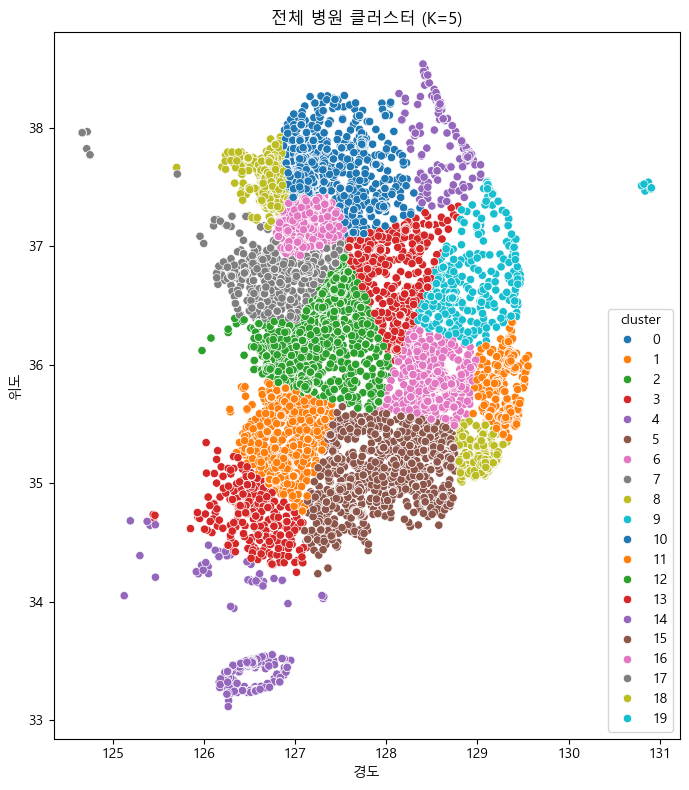

In [ ]:
plt.figure(figsize=(7, 8))
sns.scatterplot(data=coords_all, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('전체 병원 클러스터 (K=5)')


plt.xlabel('경도')
plt.ylabel('위도')
plt.tight_layout()
plt.show()

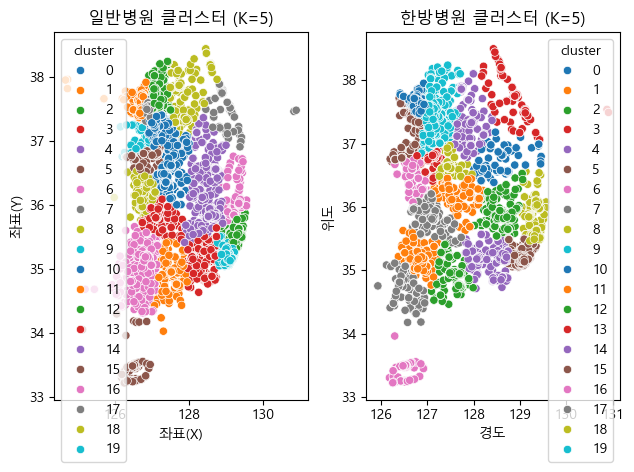

In [ ]:
plt.subplot(1, 2, 1)
sns.scatterplot(data=coords_general, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('일반병원 클러스터 (K=5)')

plt.subplot(1, 2, 2)
sns.scatterplot(data=coords_oriental, x='좌표(X)', y='좌표(Y)', hue='cluster', palette='tab10')
plt.title('한방병원 클러스터 (K=5)')

plt.xlabel('경도')
plt.ylabel('위도')
plt.tight_layout()
plt.show()

In [ ]:
coords_all['cluster'].value_counts().sort_index()

cluster
0     19171
1      2412
2      4684
3       927
4      1096
5      2723
6      5584
7       456
8      6641
9       298
10     1486
11     3517
12     2649
13     1121
14      578
15     1476
16     8064
17     1713
18    13268
19      595
Name: count, dtype: int64

In [ ]:
coords_all.groupby('cluster')[['좌표(X)', '좌표(Y)']].mean()

,좌표(X),좌표(Y)
cluster,,
0,127.052837,37.566011
1,129.321977,35.725137
2,127.419287,36.422048
3,126.515131,34.748278
4,126.504188,33.473750
5,128.462161,35.165249
6,128.574835,35.879802
7,126.480762,36.866666
8,129.046708,35.186242


In [ ]:
for c in sorted(coords_all['cluster'].unique()):
    idx = coords_all[coords_all['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())
    


클러스터 0 주요 지역: {'서울': 15296, '경기': 3837, '강원': 38}
클러스터 1 주요 지역: {'울산': 1422, '경북': 989, '경남': 1}
클러스터 2 주요 지역: {'대전': 2355, '충북': 1442, '세종': 449, '충남': 301, '경남': 82}
클러스터 3 주요 지역: {'전남': 927}
클러스터 4 주요 지역: {'제주': 1043, '전남': 53}
클러스터 5 주요 지역: {'경남': 2723}
클러스터 6 주요 지역: {'대구': 4168, '경북': 1289, '경남': 127}
클러스터 7 주요 지역: {'충남': 430, '인천': 19, '경기': 7}
클러스터 8 주요 지역: {'부산': 5585, '경남': 1049, '울산': 7}
클러스터 9 주요 지역: {'강원': 220, '경북': 78}
클러스터 10 주요 지역: {'강원': 1102, '경기': 368, '충북': 16}
클러스터 11 주요 지역: {'광주': 2325, '전북': 641, '전남': 551}
클러스터 12 주요 지역: {'전북': 2121, '충남': 516, '경남': 12}
클러스터 13 주요 지역: {'충북': 638, '경북': 446, '강원': 37}
클러스터 14 주요 지역: {'강원': 578}
클러스터 15 주요 지역: {'전남': 1100, '경남': 237, '전북': 139}
클러스터 16 주요 지역: {'경기': 8036, '충남': 28}
클러스터 17 주요 지역: {'충남': 1586, '충북': 108, '세종': 15, '경기': 4}
클러스터 18 주요 지역: {'경기': 5501, '서울': 3969, '인천': 3798}
클러스터 19 주요 지역: {'경북': 593, '대구': 2}


In [ ]:
print('[일반병원]')
for c in sorted(coords_general['cluster'].unique()):
    idx = coords_general[coords_general['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())

[일반병원]
클러스터 0 주요 지역: {'대전': 1264, '충북': 930, '세종': 239, '충남': 142, '전북': 10}
클러스터 1 주요 지역: {'전남': 540, '전북': 64, '경남': 53}
클러스터 2 주요 지역: {'서울': 6760, '경기': 2072, '강원': 17}
클러스터 3 주요 지역: {'경남': 1402, '경북': 12}
클러스터 4 주요 지역: {'대구': 2261, '경북': 638, '경남': 76}
클러스터 5 주요 지역: {'제주': 541, '전남': 11}
클러스터 6 주요 지역: {'광주': 1310, '전남': 733, '전북': 145}
클러스터 7 주요 지역: {'강원': 268, '경북': 18}
클러스터 8 주요 지역: {'충남': 242, '전북': 213}
클러스터 9 주요 지역: {'충남': 108, '경기': 98, '인천': 4}
클러스터 10 주요 지역: {'경기': 3350, '충남': 10, '충북': 7}
클러스터 11 주요 지역: {'인천': 2045, '경기': 1855, '서울': 93}
클러스터 12 주요 지역: {'울산': 742, '경남': 31, '경북': 21, '부산': 4}
클러스터 13 주요 지역: {'전북': 1026, '경남': 24, '충남': 13}
클러스터 14 주요 지역: {'경북': 337, '충북': 101, '강원': 22}
클러스터 15 주요 지역: {'충남': 813, '세종': 5, '충북': 3}
클러스터 16 주요 지역: {'경북': 579}
클러스터 17 주요 지역: {'서울': 3730, '경기': 1782}
클러스터 18 주요 지역: {'강원': 643, '경기': 82, '충북': 3}
클러스터 19 주요 지역: {'부산': 3036, '경남': 522}


In [ ]:
print('[한방병원]')
for c in sorted(coords_oriental['cluster'].unique()):
    idx = coords_oriental[coords_oriental['cluster'] == c].index
    top_sido = df_final.loc[idx, '시도코드명'].value_counts().head(5)
    print(f"클러스터 {c} 주요 지역:", top_sido.to_dict())

[한방병원]
클러스터 0 주요 지역: {'서울': 1341, '경기': 888, '인천': 198}
클러스터 1 주요 지역: {'광주': 329, '전남': 101, '전북': 29}
클러스터 2 주요 지역: {'대구': 910, '경북': 273, '경남': 22}
클러스터 3 주요 지역: {'충남': 264, '세종': 2}
클러스터 4 주요 지역: {'강원': 219, '충북': 123, '경기': 34}
클러스터 5 주요 지역: {'부산': 1152, '경남': 209, '울산': 7}
클러스터 6 주요 지역: {'제주': 199}
클러스터 7 주요 지역: {'전북': 490, '충남': 46, '경남': 9}
클러스터 8 주요 지역: {'울산': 268, '경북': 217}
클러스터 9 주요 지역: {'경기': 1520, '충남': 16, '충북': 5}
클러스터 10 주요 지역: {'경북': 169, '충북': 10, '강원': 4}
클러스터 11 주요 지역: {'대전': 506, '충남': 53, '충북': 38, '경북': 32, '경남': 15}
클러스터 12 주요 지역: {'전남': 190, '경남': 18, '전북': 16}
클러스터 13 주요 지역: {'강원': 172, '경북': 5}
클러스터 14 주요 지역: {'경남': 539}
클러스터 15 주요 지역: {'인천': 503, '경기': 242, '충남': 79}
클러스터 16 주요 지역: {'충남': 137}
클러스터 17 주요 지역: {'전남': 150}
클러스터 18 주요 지역: {'충북': 281, '세종': 98, '경북': 1}
클러스터 19 주요 지역: {'서울': 2303, '경기': 726, '강원': 20}


## 3. 진료과목 정보 데이터 분석

### 3-1. 데이터 전처리   

데이터 : csv로 변환한 엑셀파일. 데이터의 구조를 살펴보고 전처리 작업을 진행합니다.   
닫아놓을거임

In [396]:
df_detail = pd.read_csv(r"data/병원2.csv",encoding='utf-8')

In [397]:
df_detail.head()

,암호화요양기호,요양기관명,진료과목코드,진료과목코드명,과목별 전문의수,선택진료 의사수
0,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,가톨릭대학교 여의도성모병원,1,내과,34,0
1,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,중앙대학교병원,1,내과,59,0
2,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQyIy...,한림대학교 강남성심병원,1,내과,39,0
3,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,한림대학교 한강성심병원,1,내과,1,0
4,JDQ4MTg4MSM1MSMkMSMkMCMkODkkMzgxMzUxIzExIyQxIy...,서울대학교병원,1,내과,183,0


In [398]:
df_detail.isnull().sum() # 결측치 확인

암호화요양기호     0
요양기관명       0
진료과목코드      0
진료과목코드명     0
과목별 전문의수    0
선택진료 의사수    0
dtype: int64

In [399]:
df_detail['진료과목코드명'].unique()

array(['내과', '신경과', '정신건강의학과', '외과', '정형외과', '신경외과', '심장혈관흉부외과', '성형외과',
       '마취통증의학과', '산부인과', '소아청소년과', '안과', '이비인후과', '피부과', '비뇨의학과',
       '영상의학과', '방사선종양학과', '병리과', '진단검사의학과', '결핵과', '재활의학과', '핵의학과',
       '가정의학과', '응급의학과', '직업환경의학과', '예방의학과', '치과', '구강악안면외과', '치과보철과',
       '치과교정과', '소아치과', '치주과', '치과보존과', '구강내과', '영상치의학과', '구강병리과', '예방치과',
       '통합치의학과', '한방내과', '한방부인과', '한방소아과', '한방안·이비인후·피부과', '한방신경정신과',
       '침구과', '한방재활의학과', '사상체질과', '한방응급'], dtype=object)

In [400]:
df_detail.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 414896 entries, 0 to 414895
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   암호화요양기호   414896 non-null  object
 1   요양기관명     414896 non-null  object
 2   진료과목코드    414896 non-null  int64 
 3   진료과목코드명   414896 non-null  object
 4   과목별 전문의수  414896 non-null  int64 
 5   선택진료 의사수  414896 non-null  int64 
dtypes: int64(3), object(3)
memory usage: 19.0+ MB


내과, 이비인후과, 심장혈관흉부외과, 소아청소년과, 재할의학과, 결핵과, 한방내과, 한방소아과, 한방안·이비인후·피부과, 한방재활의학과 고름.  
하단 내용 참고함^,^...

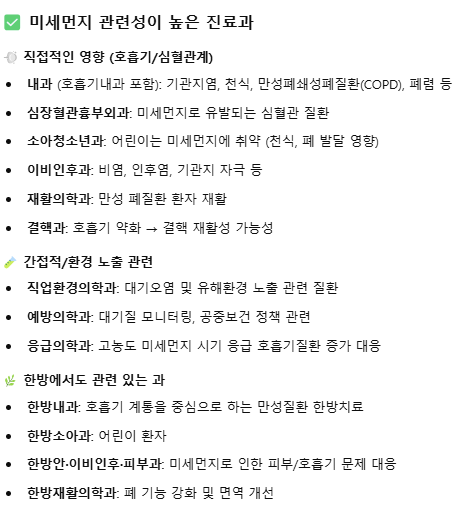

In [401]:
dust_related_depts = [
    '내과', '이비인후과', '심장혈관흉부외과', '소아청소년과',
    '재활의학과', '결핵과', '한방내과', '한방소아과',
    '한방안·이비인후·피부과', '한방재활의학과'
]

df_detail = df_detail[df_detail['진료과목코드명'].isin(dust_related_depts)]

df_detail.drop(columns=['암호화요양기호','진료과목코드'],inplace=True)

In [402]:
df_detail['진료과목코드명'].unique()

array(['내과', '심장혈관흉부외과', '소아청소년과', '이비인후과', '결핵과', '재활의학과', '한방내과',
       '한방소아과', '한방안·이비인후·피부과', '한방재활의학과'], dtype=object)

In [403]:
df_detail.head()

,요양기관명,진료과목코드명,과목별 전문의수,선택진료 의사수
0,가톨릭대학교 여의도성모병원,내과,34,0
1,중앙대학교병원,내과,59,0
2,한림대학교 강남성심병원,내과,39,0
3,한림대학교 한강성심병원,내과,1,0
4,서울대학교병원,내과,183,0


In [404]:
df_detail = pd.merge(df_detail, df_final[['요양기관명', '좌표(X)', '좌표(Y)','시도코드명','시군구코드명','읍면동']], on='요양기관명', how='left')


In [405]:
df_detail.head()

,요양기관명,진료과목코드명,과목별 전문의수,선택진료 의사수,좌표(X),좌표(Y),시도코드명,시군구코드명,읍면동
0,가톨릭대학교 여의도성모병원,내과,34,0,126.936752,37.518325,서울,영등포구,여의도동
1,중앙대학교병원,내과,59,0,126.960784,37.506748,서울,동작구,흑석동
2,한림대학교 강남성심병원,내과,39,0,126.908653,37.493726,서울,영등포구,대림동
3,한림대학교 한강성심병원,내과,1,0,126.909681,37.523170,서울,영등포구,영등포동7가
4,서울대학교병원,내과,183,0,126.999017,37.579715,서울,종로구,연건동


In [406]:
df_detail[['좌표(X)', '좌표(Y)']].isna().any(axis=1).sum()

1

In [407]:
df_detail['진료과목코드명'].value_counts()

진료과목코드명
한방내과            110656
내과              101879
한방소아과           101221
한방안·이비인후·피부과     97729
한방재활의학과          85542
소아청소년과           77866
이비인후과            70822
재활의학과            21666
심장혈관흉부외과          3051
결핵과                931
Name: count, dtype: int64

In [408]:
df_detail.isnull().sum()

요양기관명       0
진료과목코드명     0
과목별 전문의수    0
선택진료 의사수    0
좌표(X)       1
좌표(Y)       1
시도코드명       1
시군구코드명      1
읍면동         1
dtype: int64

In [409]:
df_detail[df_detail['좌표(X)'].isna() & df_detail['좌표(Y)'].isna()]

,요양기관명,진료과목코드명,과목별 전문의수,선택진료 의사수,좌표(X),좌표(Y),시도코드명,시군구코드명,읍면동
97963,광주교도소부속의원,내과,0,0,NaN,NaN,NaN,NaN,NaN


In [410]:
#광주교도소부속의원은 삭제하겠음.
df_detail = df_detail[df_detail['요양기관명'] != '광주교도소부속의원']
df_detail[df_detail['좌표(X)'].isna() & df_detail['좌표(Y)'].isna()]

,요양기관명,진료과목코드명,과목별 전문의수,선택진료 의사수,좌표(X),좌표(Y),시도코드명,시군구코드명,읍면동


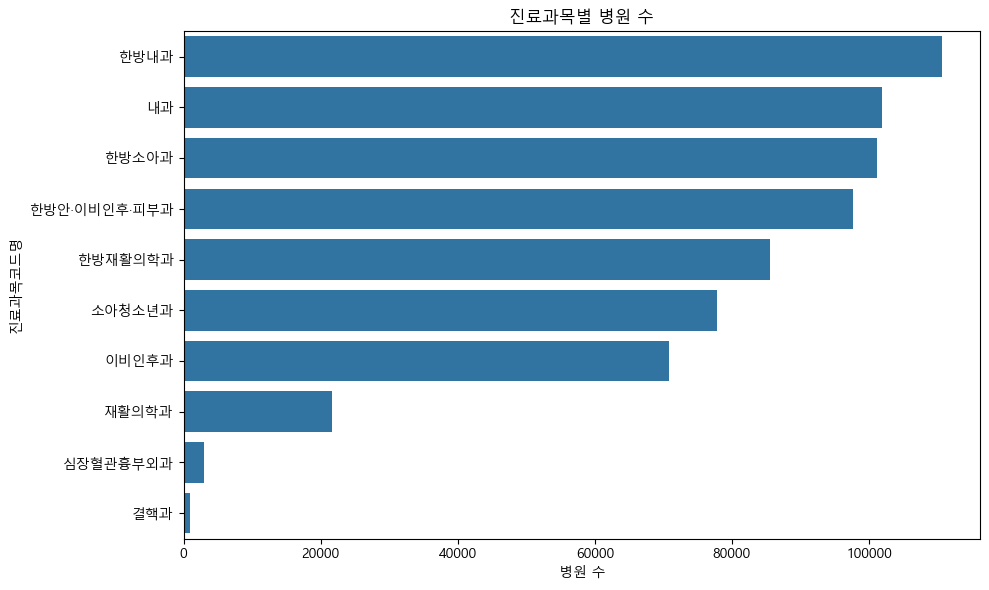

In [411]:
plt.rc('font', family='Malgun Gothic')

counts = df_detail['진료과목코드명'].value_counts()
plt.figure(figsize=(10,6))
sns.barplot(y=counts.index, x=counts.values)
plt.title("진료과목별 병원 수")
plt.xlabel("병원 수")
plt.tight_layout()
plt.show()

In [413]:
# 1. 병원 df를 GeoDataFrame으로 변환
df_detail['geometry'] = df_detail.apply(lambda row: Point(row['좌표(X)'], row['좌표(Y)']), axis=1)
df_detail = gpd.GeoDataFrame(df_detail, geometry='geometry', crs="EPSG:4326")

# 2. 생활권 GeoJSON 불러오기
gdf_living = gpd.read_file("data/only생활권.geojson")
gdf_living['ID'] = gdf_living['ID'].astype(int)

# 3. 공간 조인 (병원이 포함된 생활권 ID를 매핑)
df_detail = gpd.sjoin(df_detail, gdf_living[['ID', 'geometry']], how='left', predicate='within')

# 5. 필요시 저장
# df_final.to_file("병원_생활권_매핑결과.geojson", driver="GeoJSON")
df_detail

,요양기관명,진료과목코드명,과목별 전문의수,선택진료 의사수,좌표(X),좌표(Y),시도코드명,시군구코드명,읍면동,geometry,index_right,ID
0,가톨릭대학교 여의도성모병원,내과,34,0,126.936752,37.518325,서울,영등포구,여의도동,POINT (126.93675 37.51833),250.0,251.0
1,중앙대학교병원,내과,59,0,126.960784,37.506748,서울,동작구,흑석동,POINT (126.96078 37.50675),269.0,270.0
2,한림대학교 강남성심병원,내과,39,0,126.908653,37.493726,서울,영등포구,대림동,POINT (126.90865 37.49373),262.0,263.0
3,한림대학교 한강성심병원,내과,1,0,126.909681,37.523170,서울,영등포구,영등포동7가,POINT (126.90968 37.52317),249.0,250.0
4,서울대학교병원,내과,183,0,126.999017,37.579715,서울,종로구,연건동,POINT (126.99902 37.57972),3.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
671358,더행복요양병원,한방재활의학과,0,0,126.704166,37.454260,인천,인천남동구,구월동,POINT (126.70417 37.45426),668.0,672.0
671359,안양서울 대효요양병원,한방재활의학과,0,0,126.918372,37.398955,경기,안양만안구,안양동,POINT (126.91837 37.39896),1022.0,1027.0
671360,삼성우리요양병원,한방재활의학과,0,0,127.041961,37.214627,경기,화성시,진안동,POINT (127.04196 37.21463),1348.0,1358.0
671361,로하스용인요양병원,한방재활의학과,0,0,127.198640,37.235046,경기,용인처인구,김량장동,POINT (127.19864 37.23505),1268.0,1278.0


In [414]:
# 1. 데이터 불러오기
gdf_zone = gpd.read_file("data/only생활권.geojson")

# 2. 취약인구수 계산
gdf_zone["취약인구수"] = gdf_zone["어린이"] + gdf_zone["노인"]

# 3. 진료과목별 병원 수 및 전문의 수 계산
df_detail["전문의수"] = df_detail["과목별 전문의수"] + df_detail["선택진료 의사수"]

# 4. 생활권 ID별 진료과목별 집계
grouped = df_detail.groupby(["ID", "진료과목코드명"]).agg(
    병원수=("요양기관명", "count"),
    전문의수=("전문의수", "sum")
).reset_index()

# 5. 피벗으로 ID 기준 wide 형태로 변환
pivot_hospital = grouped.pivot(index="ID", columns="진료과목코드명", values="병원수").add_prefix("병원수_")
pivot_doctor = grouped.pivot(index="ID", columns="진료과목코드명", values="전문의수").add_prefix("전문의수_")

# 6. 병원수와 전문의수를 합침
df_medical = pd.concat([pivot_hospital, pivot_doctor], axis=1).reset_index()

# 7. 생활권 geojson과 병합
gdf_result = gdf_zone.merge(df_medical, on="ID", how="left")
gdf_result = gdf_result.fillna(0)  # 결측값 0으로 처리


m = folium.Map(location=[36.5, 127.8], zoom_start=7)

gdf_result.columns
# 8. 저장
#gdf_result.to_file("생활권_의료상세.geojson", driver="GeoJSON")

Index(['ID', 'adm_nm', 'adm_cd2', 'sgg', 'sido', 'sidonm', 'sggnm', 'adm_cd',
       '시도', '시군구', '읍면동', '행정기관코드', '총인구수', '어린이', '노인', 'geometry', '취약인구수',
       '병원수_결핵과', '병원수_내과', '병원수_소아청소년과', '병원수_심장혈관흉부외과', '병원수_이비인후과',
       '병원수_재활의학과', '병원수_한방내과', '병원수_한방소아과', '병원수_한방안·이비인후·피부과', '병원수_한방재활의학과',
       '전문의수_결핵과', '전문의수_내과', '전문의수_소아청소년과', '전문의수_심장혈관흉부외과', '전문의수_이비인후과',
       '전문의수_재활의학과', '전문의수_한방내과', '전문의수_한방소아과', '전문의수_한방안·이비인후·피부과',
       '전문의수_한방재활의학과'],
      dtype='object')

In [ ]:
target_cols = [
    '병원수_내과', '전문의수_내과',
    '병원수_이비인후과', '전문의수_이비인후과',
    '병원수_결핵과', '전문의수_결핵과'
]

# 1. 정규화
scaler = MinMaxScaler()
gdf_map_scaled = gdf_result.copy()
gdf_map_scaled[target_cols] = scaler.fit_transform(gdf_map_scaled[target_cols])

# 2. 과목별 지수 계산 (가중합: 병원 수 40%, 전문의 수 60%)
for subject in ['내과', '이비인후과', '결핵과']:
    hosp_col = f'병원수_{subject}'
    doc_col = f'전문의수_{subject}'
    gdf_map_scaled[f'{subject}_지수'] = 0.4 * gdf_map_scaled[hosp_col] + 0.6 * gdf_map_scaled[doc_col]

gdf_map_scaled['의료종합지수'] = gdf_map_scaled[[f'{s}_지수' for s in ['내과', '이비인후과', '결핵과']]].mean(axis=1)

# 인구 1만명당 의사 수 = (전문의 수 / 총인구수) * 1000
for subject in ['내과', '이비인후과', '결핵과']:
    gdf_result[f'의사밀도_{subject}'] = gdf_result[f'전문의수_{subject}'] / gdf_result['총인구수'] * 1000


gdf_map_scaled['의료지수_루트'] = np.sqrt(gdf_map_scaled['의료종합지수'])

# 색상 맵 정의
colormap = cm.linear.YlOrRd_09.scale(
    gdf_map_scaled['의료지수_루트'].min(),
    gdf_map_scaled['의료지수_루트'].max()
)
colormap.caption = "생활권 의료 종합 지수 (루트 스케일)"

# 지도 생성
m = folium.Map(location=[36.5, 127.8], zoom_start=7)
# GeoJson 시각화
folium.GeoJson(
    gdf_map_scaled,
    name="생활권 의료 종합 지수",
    tooltip=folium.GeoJsonTooltip(
        fields=["ID", "읍면동", "총인구수", "어린이", "노인", "의료지수_루트"],
        aliases=["ID", "읍면동", "총인구수", "어린이", "노인", "의료지수_루트"],
        localize=True
    ),
    style_function=lambda feature: {
        "fillColor": colormap(feature["properties"]["의료지수_루트"]) if feature["properties"]["의료지수_루트"] else "lightgray",
        "color": "black",
        "weight": 0.3,
        "fillOpacity": 0.7,
    },
).add_to(m)

colormap.add_to(m)
# 10. 저장  
m.save("생활권_병원2.html")


In [415]:
threshold = gdf_map_scaled['의료종합지수'].quantile(0.2)
gdf_map_scaled['의료취약'] = gdf_map_scaled['의료종합지수'] <= threshold

In [416]:
gdf_map_scaled

,ID,adm_nm,adm_cd2,sgg,sido,sidonm,sggnm,adm_cd,시도,시군구,...,전문의수_한방내과,전문의수_한방소아과,전문의수_한방안·이비인후·피부과,전문의수_한방재활의학과,내과_지수,이비인후과_지수,결핵과_지수,의료종합지수,의료지수_루트,의료취약
0,1,서울특별시 종로구 사직동,1111053000,11110,11,서울특별시,종로구,11010530,서울특별시;서울특별시;서울특별시,종로구;종로구;종로구,...,2.0,0.0,0.0,1.0,0.146997,0.043200,0.0,0.063399,0.251792,False
1,2,서울특별시 종로구 부암동,1111055000,11110,11,서울특별시,종로구,11010550,서울특별시;서울특별시,종로구;종로구,...,1.0,0.0,0.0,0.0,0.006612,0.004301,0.0,0.003638,0.060312,True
2,3,서울특별시 종로구 무악동,1111057000,11110,11,서울특별시,종로구,11010570,서울특별시;서울특별시,종로구;종로구,...,0.0,0.0,0.0,0.0,0.231824,0.229257,0.0,0.153693,0.392038,False
3,4,서울특별시 종로구 가회동,1111060000,11110,11,서울특별시,종로구,11010600,서울특별시;서울특별시;서울특별시;서울특별시,종로구;종로구;종로구;종로구,...,20.0,1.0,1.0,5.0,0.603725,0.380279,0.0,0.328001,0.572714,False
4,5,서울특별시 종로구 창신1동,1111067000,11110,11,서울특별시,종로구,11010670,서울특별시;서울특별시;서울특별시,종로구;종로구;종로구,...,7.0,1.0,2.0,0.0,0.349333,0.107858,0.1,0.185730,0.430964,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2110,2123,전북특별자치도 고창군 고수면,5279031000,52790,52,전북특별자치도,고창군,35570310,전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치...,고창군;고창군;고창군;고창군;고창군;고창군;고창군;고창군;고창군,...,0.0,0.0,0.0,0.0,0.116716,0.047312,0.0,0.054676,0.233829,False
2111,2124,전북특별자치도 고창군 흥덕면,5279040000,52790,52,전북특별자치도,고창군,35570400,전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치도,고창군;고창군;고창군;고창군,...,0.0,0.0,0.0,0.0,0.055074,0.032258,0.0,0.029111,0.170619,False
2112,2125,전북특별자치도 부안군 부안읍,5280025000,52800,52,전북특별자치도,부안군,35580110,전북특별자치도,부안군,...,9.0,1.0,2.0,1.0,0.097851,0.028004,0.0,0.041952,0.204821,False
2113,2126,전북특별자치도 부안군 주산면,5280031000,52800,52,전북특별자치도,부안군,35580310,전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치도;전북특별자치...,부안군;부안군;부안군;부안군;부안군;부안군;부안군;부안군;부안군,...,0.0,0.0,0.0,0.0,0.062722,0.034409,0.0,0.032377,0.179936,False


In [417]:

gdf_map_scaled.to_file("생활권_병원2.geojson", driver="GeoJSON")
gdf_map_scaled.to_csv("병원2_취약생활권_결과.csv", index=False, encoding='utf-8-sig')

# 결론

세종,광주,대전 밷.